In [24]:
import numpy as np

from dataset_loader import load_from_file
from tabulate import tabulate
from matplotlib.pyplot import figure, imshow, axis
from commons import *
from skimage import data, util
from skimage.measure import label, regionprops
from scipy.ndimage import rotate
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data
from skimage.transform import probabilistic_hough_line
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

# obrót do poziomu, metodami:
# 1. hough lines
# 2. tomkowe
# 3. tamtą pierwszą biblioteką od eliciticy
# informacja wzjaemna - między jednym obrazkiem a porównywanym
# jeszcze te metryki: https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6


DOTS_DST = 'cache/dots_v2.pickle'
TRACKS_DST = 'cache/tracks_v2.pickle'
WORMS_DST = 'cache/worms_v2.pickle'
ARTIFACTS_DST = 'cache/artifacts_v2.pickle'

DOTS_DSTx4 = 'cache/dots_v3.pickle'
TRACKS_DSTx4 = 'cache/tracks_v3.pickle'
WORMS_DSTx4 = 'cache/worms_v3.pickle'
ARTIFACTS_DSTx4 = 'cache/artifacts_v3.pickle'


tf_classes = [ tf.keras.metrics.AUC,
    tf.keras.metrics.Accuracy,
    tf.keras.metrics.BinaryAccuracy,
    tf.keras.metrics.BinaryCrossentropy,
    tf.keras.metrics.BinaryIoU,
    tf.keras.metrics.CategoricalAccuracy,
    tf.keras.metrics.CategoricalCrossentropy,
    tf.keras.metrics.CategoricalHinge,
    tf.keras.metrics.CosineSimilarity,
    tf.keras.metrics.FalseNegatives,
    tf.keras.metrics.FalsePositives,
    tf.keras.metrics.Hinge,
    #tf.keras.metrics.IoU,
    tf.keras.metrics.KLDivergence,
    tf.keras.metrics.LogCoshError,
    tf.keras.metrics.Mean,
    tf.keras.metrics.MeanAbsoluteError,
    tf.keras.metrics.MeanAbsolutePercentageError,
    #tf.keras.metrics.MeanIoU,
    #tf.keras.metrics.MeanMetricWrapper,
    #tf.keras.metrics.MeanRelativeError,
    tf.keras.metrics.MeanSquaredError,
    tf.keras.metrics.MeanSquaredLogarithmicError,
    #tf.keras.metrics.MeanTensor,
    #tf.keras.metrics.Metric,
    #tf.keras.metrics.OneHotIoU,
    #tf.keras.metrics.OneHotMeanIoU,
    tf.keras.metrics.Poisson,
    tf.keras.metrics.Precision,
    #tf.keras.metrics.PrecisionAtRecall,
    tf.keras.metrics.Recall,
    #tf.keras.metrics.RecallAtPrecision,
    tf.keras.metrics.RootMeanSquaredError,
    #tf.keras.metrics.SensitivityAtSpecificity,
    tf.keras.metrics.SparseCategoricalAccuracy,
    tf.keras.metrics.SparseCategoricalCrossentropy,
    tf.keras.metrics.SparseTopKCategoricalAccuracy,
    #tf.keras.metrics.SpecificityAtSensitivity,
    tf.keras.metrics.SquaredHinge,
    tf.keras.metrics.Sum,
    tf.keras.metrics.TopKCategoricalAccuracy,
    tf.keras.metrics.TrueNegatives,
    tf.keras.metrics.TruePositives ]

def generic_tf_metrics(cls):
    def tf_metrics(image, recon):
        m = cls()
        m.update_state(image, recon)
        return m.result().numpy()
    return tf_metrics, cls.__name__

tf_mean = generic_tf_metrics(tf.keras.metrics.Mean)


def tf_kl_divergence(image, recon):
    m = tf.keras.metrics.KLDivergence()
    m.update_state(image, recon)
    return m.result().numpy()


def tf_accuracy(image, recon):
    m = tf.keras.metrics.Accuracy()
    m.update_state(image, recon)
    return m.result().numpy()

def tf_mse(image, recon):
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(image, recon)
    return m.result().numpy()




funcs = [
    (dm_func_mean2, 'mean'),
    (dm_func_avg_hash, 'avg_hash'),
    (dm_func_p_hash, 'p_hash'),
    (dm_func_d_hash,  'd_hash'),
    (dm_func_haar_hash,  'haar_hash'),
    (dm_func_db4_hash, 'db4_hash')
] #, tf_kl_divergence, tf_accuracy, tf_mse]
for c in tf_classes:
    funcs.append(generic_tf_metrics(c))


def angle(x, y):
    rad = np.arctan2(y, x)
    degrees = rad*180/np.pi
    return degrees


def round_normalize(image):
    mask = np.where(image == 0, 0.0, 1.0)
    min_var = 1000
    deg = 0
    for d in range(0, 360):
        rotated_mask = rotate(mask, d, reshape=False)
        rotated_image = rotate(image, d, reshape=False)
        rotated_image = np.where(rotated_mask < 0.25, 0, rotated_image)
        rotated_image.sort(axis=0)
        rotated_image.sort(axis=1)

        s = rotated_image.sum(axis=1)
        v = np.var(s)
        if v < min_var:
            min_var = v
            deg = d
        #print("%d: %f" % (d, v))
        #rotated_image.sort(axis=1)

    mask = np.where(image == 0, 0.0, 1.0)
    deg += 90
    rotated_mask = rotate(mask, deg, reshape=False)
    rotated_image = rotate(image, deg, reshape=False)
    rotated_image = np.where(rotated_mask < 0.25, 0, rotated_image)
    rotated_image = np.where(rotated_image < 0, 0, rotated_image)
    rotated_image = np.where(rotated_image > 1, 1, rotated_image)
    return rotated_image


def showImagesMatrix(images, col=10):

    hSize = 20
    wSize = 20

    fig = figure( figsize=(wSize, hSize))
    number_of_files = len(images)
    row = number_of_files // col
    if (number_of_files%col != 0):
        row += 1

    row_head = ['Image 0 vs image:']
    row_funcs = []

    for f, n in funcs:
        row_funcs.append([n])

    img0 = round_normalize(images[0])
    img0 = np.expand_dims(img0, axis=-1)

    img1 = round_normalize(images[0])
    img2 = round_normalize(images[0])

    for i in range(number_of_files):
        row_head.append(str(i))
        a=fig.add_subplot(row,col,i+1)
        image = round_normalize(images[i])
        image = np.expand_dims(image, axis=-1)
        imshow(image,cmap='Greys_r')
        axis('off')

        d = np.squeeze(img0, axis=2)
        e = np.squeeze(image, axis=2)

        #print('%010s | %6.3f' % ('dm_func_mean2', v))
        for fi, (f, n) in enumerate(funcs):
            v = f(img0, image)
            row_funcs[fi].append(str(v))
            a = np.squeeze(img0, axis=2)
            b = np.squeeze(image, axis=2)
            if i == 0 and fi == 0 and v != 0:
                print(a == b)
                print(d == e)
                print(image == img0)
                print('---' + str(v) + '---')

    table = [row_head, *row_funcs]
    print(tabulate(table))



images, augmented = load_from_file(TRACKS_DST)
#showImagesMatrix([augmented[16], augmented[0], augmented[2], augmented[5], images[0]], 5)
#showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

#images_worms, augmented_worms = load_from_file(WORMS_DST)
#round_normalize(images_worms[0])
#showImagesMatrix([images_worms[0], augmented_worms[0], augmented_worms[2], augmented_worms[5], augmented_worms[16]], 5)

-----------------------------  -------------  ----------------  -------------  ----------------  ---------------
Image 0 vs image:                 0                1               2                3                4
mean                              0              -11.7167          0               -8.82389         -9.49468
avg_hash                          0                0               0                0                0
p_hash                            0                0.0302457       0                0.0604915        0.0604915
d_hash                            0                0               0                0                0
haar_hash                         0                0.0189036       0                0.0226843        0.0226843
db4_hash                          0                0.0283554       0                0.0396975        0.0283554
AUC                               1                0.999885        1                0.890934         0.934692
Accuracy                  

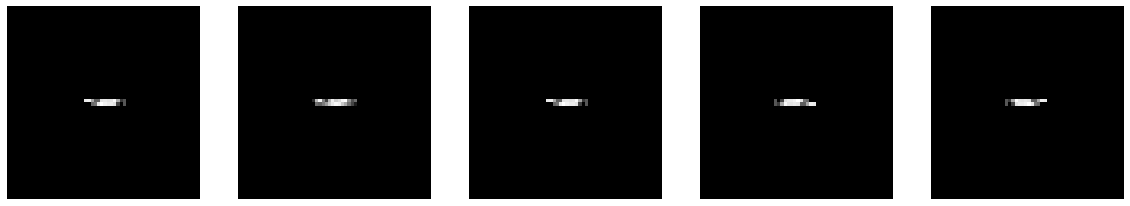

In [25]:
showImagesMatrix([images[0], augmented[0], augmented[2], augmented[5], augmented[16]], 5)

-----------------------------  -------------  ---------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0               1                 2                 3                 4
mean                              0              -9.27886          -9.51408          -8.07269          -7.56966
avg_hash                          0               0                 0                 0.00378072        0.00378072
p_hash                            0               0.0226843         0.0226843         0.0831758         0.0226843
d_hash                            0               0.00378072        0.00378072        0.00378072        0.00567108
haar_hash                         0               0.0226843         0.020794          0.0226843         0.026465
db4_hash                          0               0.0604915         0.0415879         0.145558          0.0812854
AUC                               1               0.825898          0.825844          0.71631  

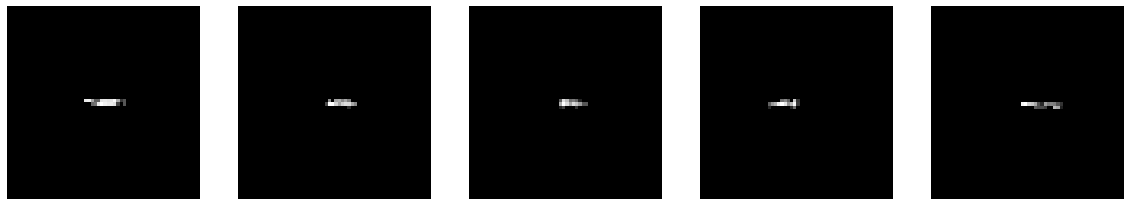

In [26]:
showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

-----------------------------  --------------  ----------------  --------------  ----------------  ----------------
Image 0 vs image:                 0                 1               2                 3                 4
mean                              0                -3.3049          0                -3.22864          -3.22864
avg_hash                          0                 0               0                 0                 0
p_hash                            0                 8               0                 8                 8
d_hash                            0                 0               0                 0                 0
haar_hash                         0                 6.5             0                 7.5               7.5
db4_hash                          0                17.5             0                16.75             18.75
AUC                               1                 0.499444        1                 0.499722          0.499722
Accuracy          

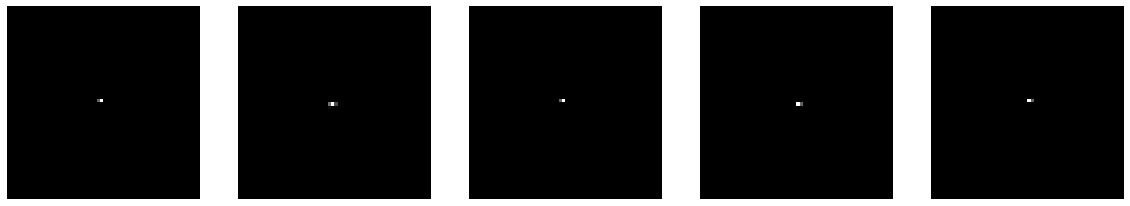

In [27]:
images_dots, augmented_dots = load_from_file(DOTS_DST)

showImagesMatrix([images_dots[0], augmented_dots[0], augmented_dots[2], augmented_dots[5], augmented_dots[16]], 5)

-----------------------------  --------------  ---------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0                1                 2                 3                 4
mean                              0               -4.24104          -4.91198          -0.918602         -1.7526
avg_hash                          0                0                 0                 0                 0
p_hash                            0                0                 0                 8                 0
d_hash                            0                0.25              0                 0.25              0.5
haar_hash                         0                3.75              1                 6.25              1.25
db4_hash                          0               11.75              1.25             17.25              6.5
AUC                               1                1                 0.999861          0.499166          0.999861
Accuracy

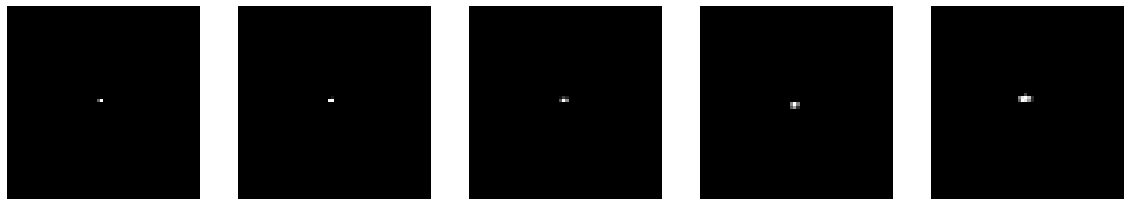

In [28]:
showImagesMatrix([images_dots[0], images_dots[1], images_dots[2], images_dots[3], images_dots[4]], 5)

-----------------------------  -------------  ---------------  -------------  --------------  --------------
Image 0 vs image:                 0               1               2              3               4
mean                              0             -16.9267          0             -8.90664        -9.11384
avg_hash                          0               0               0              0.000711997     0.000711997
p_hash                            0               0               0              0.011392        0.011392
d_hash                            0               0               0              0.00213599      0.00142399
haar_hash                         0               0.00320399      0              0.00854397      0.00711997
db4_hash                          0               0.00462798      0              0.0291919       0.0274119
AUC                               1               0.990557        1              0.550591        0.646433
Accuracy                          1        

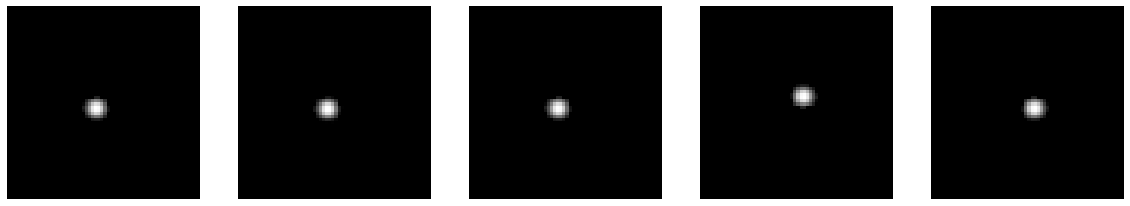

In [29]:
images_dots4x, augmented_dots4x = load_from_file(DOTS_DSTx4)
showImagesMatrix([images_dots4x[0], augmented_dots4x[0], augmented_dots4x[2], augmented_dots4x[5], augmented_dots4x[16]], 5)

-----------------------------  -------------  --------------  --------------  --------------  --------------
Image 0 vs image:                 0              1               2               3               4
mean                              0             -8.18013        -8.40474        -6.62513        -6.76728
avg_hash                          0              0.000711997     0.000355999     0.001068        0.00213599
p_hash                            0              0.011392        0.011392        0.011392        0.011392
d_hash                            0              0.00249199      0.000355999     0.00213599      0.00213599
haar_hash                         0              0.00889996      0.00640797      0.0135279       0.00925596
db4_hash                          0              0.0320399       0.0227839       0.0469918       0.0327519
AUC                               1              0.691477        0.624233        0.638597        0.60232
Accuracy                          1          

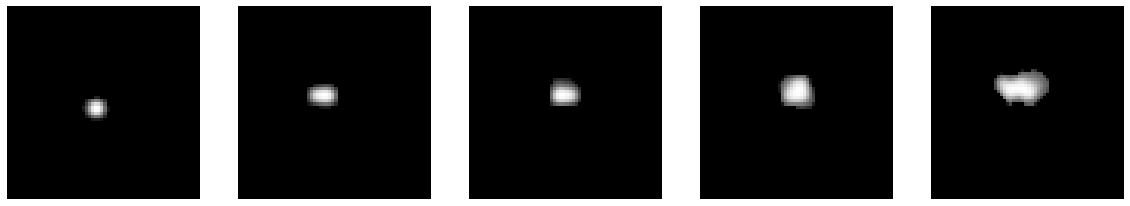

In [30]:
showImagesMatrix([images_dots4x[0], images_dots4x[1], images_dots4x[2], images_dots4x[3], images_dots4x[4]], 5)

-----------------------------  -------------  ---------------  --------------  --------------  ----------------
Image 0 vs image:                 0               1               2               3                 4
mean                              0             -14.9119         -7.85535        -7.85535          -9.09765
avg_hash                          0               0               0               0                 0
p_hash                            0               0               0.0332986       0.0332986         0.0332986
d_hash                            0               0.00104058      0.00208117      0.00208117        0
haar_hash                         0               0.00104058      0.012487        0.012487          0
db4_hash                          0               0.00208117      0.0312175       0.0312175         0.0197711
AUC                               1               0.967692        0.56063         0.56063           0.691519
Accuracy                          1        

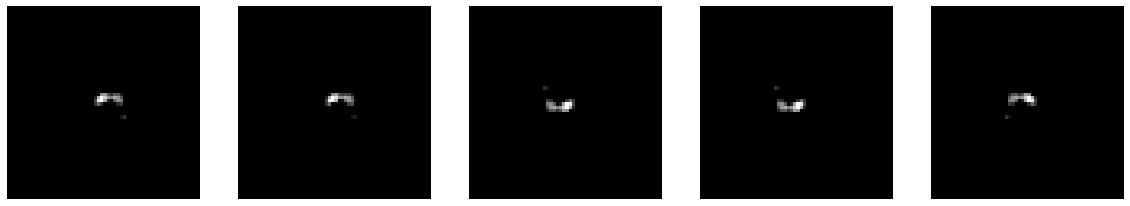

In [31]:
images_worms, augmented_worms = load_from_file(WORMS_DST)
showImagesMatrix([images_worms[0], augmented_worms[0], augmented_worms[2], augmented_worms[5], augmented_worms[16]], 5)

-----------------------------  -------------  ----------------  --------------  --------------  --------------
Image 0 vs image:                 0                1               2               3               4
mean                              0               -8.82796        -7.08274        -7.62399        -6.84479
avg_hash                          0                0.00104058      0.00208117      0.00416233      0
p_hash                            0                0.0332986       0.00416233      0.049948        0.0332986
d_hash                            0                0               0               0.00208117      0.00312175
haar_hash                         0                0.0228928       0.0145682       0.0270552       0.0187305
db4_hash                          0                0.069719        0.0707596       0.0738814       0.0530697
AUC                               1                0.725065        0.819878        0.59442         0.675933
Accuracy                          1

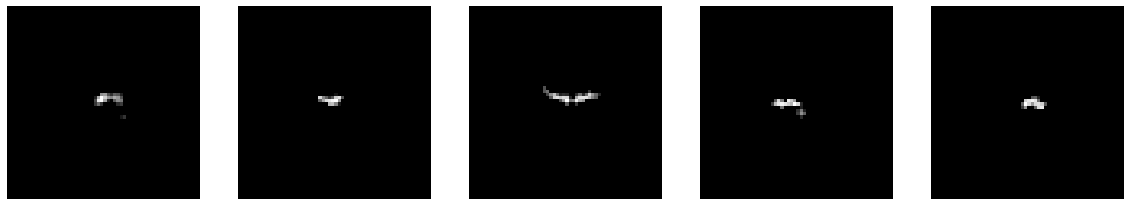

In [32]:
showImagesMatrix([images_worms[0], images_worms[1], images_worms[2], images_worms[3], images_worms[4]], 5)

-----------------------------  -------------  ----------------  --------------  --------------
Image 0 vs image:                 0                1               2               3
mean                              0               -7.51914        -8.0103         -6.99381
avg_hash                          0                0               0               0.00189036
p_hash                            0                0.0378072       0.0378072       0.0831758
d_hash                            0                0.00189036      0.00378072      0.00567108
haar_hash                         0                0.0151229       0.0396975       0.0396975
db4_hash                          0                0.0586011       0.155009        0.073724
AUC                               1                0.758189        0.543478        0.755661
Accuracy                          1                0.988333        0.993611        0.982222
BinaryAccuracy                    0.993611         0.993611        0.993611    

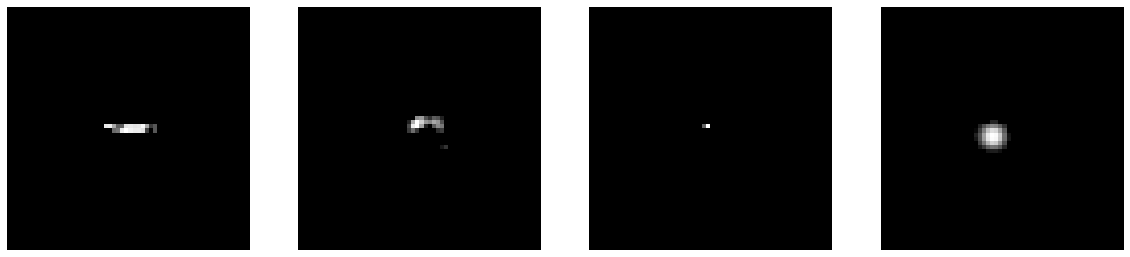

In [33]:
showImagesMatrix([images[0], images_worms[0], images_dots[0], images_dots4x[0][2:62,2:62]], 4)